# Metodologías para cálculo del VaR

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 29 19:17:15 2020
@author: eilinlunam
"""

# IMPORTANDO LIBRERIAS
from scipy.stats import norm, kurtosis, t, chi2
from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import numpy as np
import investpy

#Parámetros de ingreso:
    # stocks --> Lista de acciones ["stock1","stock2","stock3"]
    # pais --> str "united states"
    # dinero --> Lista de inversiones [1000, 1000, 1000]
    # desde --> fecha str "01/01/2020"
    # hasta --> fecha str "10/11/2020"
    # alphas --> Lista [0.1, 0.2, 0.3]
    # periodos --> 277 dias (modificable por el usuario)
    # dias --> (Numero de datos - periodos)  --> Ya no es 252 dias.
    
class Metodologias:
    
    def __init__(self, stocks, dinero, desde, hasta, alphas, 
                 pais="united states", periodos=277, landa=0.94):
        # Instancias: 
        self.stocks = stocks   
        self.country = pais    
        self.money = dinero   
        self.start = desde
        self.end = hasta
        self.alphas = alphas   
        self.periodos = periodos  
        self.landa = landa
        self.n = len(stocks)  # Cantidad de activos
        self.W = np.array(dinero)/np.sum(dinero)  # Vector de participaciones
        self.data = self.get_data()  #Datos: Fecha, PrecioActivo1, PrecioActivo2, ..., PrecioActivon
        self.rent = self.get_rentabilidades() #Rent: Fecha, RentActivo1, RentActivo2,...,RentActivon  
        self.rend = self.get_rendimiento() # Rend: Fecha, RendPortafolio
        self.N = len(self.data)-1  # Cantidad total de datos
        self.dias = self.N - self.periodos 
        self.a = self.N-self.periodos-self.dias  
        self.b = self.N-self.periodos
        self.fechas = self.get_fechas()
    
    
    """
    # Descargando valores de cada accion en Investing
    def get_data(self):
        # Nota: Si se usa Investing toca especificar el pais. (united state por defecto)
        inicio = pd.to_datetime(self.start, format="%Y-%m-%d").strftime("%d/%m/%Y") 
        final = pd.to_datetime(self.end, format="%Y-%m-%d").strftime("%d/%m/%Y") 
        data = pd.DataFrame()
        if self.stocks!=[]:
            for i in self.stocks:
                try:
                    data[i] = investpy.get_stock_historical_data(
                        stock=i,country=self.country,from_date=inicio,to_date=final)['Close']
                except:
                    print("Error")
                    print(i+" no se encuentra en la base de datos de Investing")
                    inversion.pop(self.stocks.index(i))
                    stock.remove(i)
        return data
    """
    
    # Descargando valores de cada accion en Yahoo Finance
    def get_data(self):
        if self.stocks!=[]:
            try:
                yf.pdr_override 
                data = pdr.get_data_yahoo(self.stocks, start = self.start, end = self.end)
                return data["Close"]
            except:
                print("Error")
                return
    
    # Obtiene las rentabilidades: R=log(Pf/Pi)
    def get_rentabilidades(self):
        df = pd.DataFrame()
        for i in self.stocks:
            P_final = self.data[i][1:].values
            P_inicial = self.data[i][0:-1].values
            df[i] = np.log(P_final/P_inicial)
        df.index = [k.strftime("%d/%m/%Y") for k in self.data.index[1:]]
        return df

    # Calculando rendimiento del portafolio
    def get_rendimiento(self):
        Rent = (self.rent*self.W).sum(axis=1)
        return pd.DataFrame(Rent, columns=["Rent"])

    # Extrayendo fechas en el periodo escogido (277 dias (por defecto))
    def get_fechas(self):
        Fechas = self.data[self.N-self.periodos+1:self.N+1].index
        Fechas = [i.strftime("%d/%m/%Y") for i in Fechas]
        return Fechas

    # Calculando desviacion estandar por ventanas de una accion
    def get_desvest(self, s):
        return np.array([np.std(self.rent[s][self.a+j:self.b+j], ddof=1) for j in range(self.periodos)])

    # Calculando desviacion estandar como: d.j+1 = sqrt{lamda*(d.j**2) + (1-lamda)*(rent**2)}
    def get_desvest_2(self, s):
        r0 = self.rent[s][self.N-self.periodos:self.N]
        d0 = [np.std(self.rent[s][self.a:self.b], ddof=1)]
        for j in range(self.periodos-1):
            d0 += [np.sqrt(self.landa*d0[j]**2+(1-self.landa)*r0[j]**2)]
        return np.array(d0)

    # Calculando desviacion estandar como: sqrt{v-2/v}*desvest_movil
    def get_desvest_3(self, s):
        v = self.get_grados_de_libertad(self.rent[s])
        d = self.get_desvest(s)
        return np.sqrt((v-2)/v)*d

    # Calculando desviacion estandar como: d.j+1 = sqrt{v.j-2/v.j}*sqrt{lamda*(d.j**2) + (1-lamda)*(rent**2)}
    def get_desvest_4(self, s):
        v = self.get_grados_de_libertad(self.rent[s])
        r0 = self.rent[s][self.N-self.periodos:self.N]
        d0 = [np.std(self.rent[s][self.a:self.b]*np.sqrt((v[0]-2)/v[0]), ddof=1)]
        for j in range(self.periodos-1):
            d0 += [np.sqrt(self.landa*d0[j]**2+(1-self.landa)*r0[j]**2)*np.sqrt((v[j+1]-2)/v[j+1])]
        return np.array(d0)

    # Calculando media aritmetica por ventanas de una accion
    def get_mean(self, s):
        return [np.mean(self.rent[s][self.a+j:self.b+j]) for j in range(self.periodos)]

    # Calculando Grados de libertad dado las rentabilidades
    def get_grados_de_libertad(self,rent):
        GL = []
        for j in range(self.periodos):
            rango = rent[self.a+j:self.b+j]
            k = kurtosis(rango)
            GL += [np.round((4*k+6)/k)]
        return np.array(GL, dtype=int)

    # VaR Suma Simple (s=Activo)   
    def VaRSumaSimple(self,s):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        df["Rent"] = self.rent[s][self.b:self.N].values
        df["desvest"]= self.get_desvest(s)
        df["media"]  = self.get_mean(s)
        for a in self.alphas:
            Zalpha = -norm.ppf(1-a)
            df['alpha='+str(a)]=df["desvest"]*Zalpha
        return df

    # VaR Suma Simple (Portafolio)
    def VaRSumaSimplePortafolio(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        df["Rent"] = self.rend['Rent'][self.b:self.N].values
        for a in self.alphas:
            df['alpha='+str(a)]=sum([self.VaRSumaSimple(i)['alpha='+str(a)] for i in self.stocks])
        return df

    # VaR Baricentro EWMA Normal (Portafolio)
    def VaRBaricentroEWMANormal(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        df["Rent"] = self.rend['Rent'][self.b:self.N].values
        X = sum([self.get_desvest_2(self.stocks[i])*self.W[i] for i in range(self.n)])
        df["Desv_Bar_Prom_EWMA"] = X
        for a in self.alphas:
            df['alpha='+str(a)]=df["Desv_Bar_Prom_EWMA"]*-norm.ppf(1-a)
        return df

    # VaR Baricentro Promedio Normal (Portafolio)
    def VaRBaricentroPromedioNormal(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        df["Rent"] = self.rend['Rent'][self.b:self.N].values
        X = sum([self.get_desvest(self.stocks[i])*self.W[i] for i in range(self.n)])
        df["Desv_Bar_Prom"] = X
        for a in self.alphas:
            df['alpha='+str(a)]=df["Desv_Bar_Prom"]*-norm.ppf(1-a)
        return df

    # VaR Simulacion Historica (Portafolio)
    def VaRSimulacionHistorica(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        df["Rent"] = self.rend['Rent'][self.b:self.N].values
        for a in self.alphas:
            X=[np.percentile(self.rend[self.a+j:self.b+j],a*100) for j in range(self.periodos)]
            df['alpha='+str(a)]=X
        return df    

    # VaR Baricentro Promedio T (Portafolio)
    def VaRBaricentroPromedioT(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        df["Rent"] = self.rend['Rent'][self.b:self.N].values
        df['GL']=self.get_grados_de_libertad(self.rend['Rent'])
        X = sum([self.get_desvest_3(self.stocks[i])*self.W[i] for i in range(self.n)])
        df["desv"]=X
        for a in self.alphas:
            df['alpha='+str(a)]=df["desv"]*-t.ppf(1-a, df['GL'])
        return df

    # VaR Baricentro EWMA T (Portafolio)
    def VaRBaricentroEWMAT(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        df["Rent"] = self.rend['Rent'][self.b:self.N].values
        df['GL']=self.get_grados_de_libertad(self.rend['Rent'])
        X = sum([self.get_desvest_4(self.stocks[i])*self.W[i] for i in range(self.n)])
        df["desv"]=X
        for a in self.alphas:
            df['alpha='+str(a)]=df["desv"]*-t.ppf(1-a, df['GL'])
        return df
    
    # M, dataframe arrojado por el metodo usado.
    def excepciones(self, M):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        RP = self.rend['Rent'][self.b:self.N].values
        for a in self.alphas:
            df['alpha='+str(a)]=RP<M['alpha='+str(a)]
        return df  
    
    # M, dataframe arrojado por el metodo usado.
    def BackTesting(self, M):
        ex = self.excepciones(M)
        p = np.array(self.alphas)
        x = ex.sum()[1:].values
        m = ex.count()[1:].values
        p_est = x/m
        nivel = np.array([0.05]*len(self.alphas))
        BackTesting = m*p
        num = (p**x)*(1-p)**(m-x)
        den = (p_est**x)*(1-p_est)**(m-x)
        test_kupiec = -2*np.log(list(num/den))
        ValorP = chi2.pdf(test_kupiec,1)
        zona = np.where(ValorP<=nivel, "Rechazo H0", "No Rechazo H0")
        d = pd.DataFrame({'BackTesting':BackTesting, 'x':x , 'p':p, 'p estimado':p_est , 'm':m ,
                          'nivel de significancia':nivel,'test de kupiec':test_kupiec, 'Valor P':ValorP,
                          "Zona de rechazo":zona, "Valor de eficiencia": 1-p_est})
        return d.T
    
    def grafico(self,var,title):
        plt.figure(dpi=80)
        for i,act in enumerate(var.columns):
            plt.plot(var[act], label=var.columns[i])
        plt.title(title),plt.grid(),plt.legend()
        plt.xticks(np.array(var.index.values[::len(var)//12]),rotation=60)
        plt.show()

# Ejemplo 

In [2]:
activos = ["BA", "AMZN", "AAPL", "AAL", "GS"]
pais = "united states"
dinero = [100, 100, 100, 100, 100]
desde = "2018-02-14"
hasta = "2020-03-24"
alphas = [0.1,  0.05,  0.025,  0.01]

M = Metodologias(stocks=activos, 
                 dinero = dinero,
                 desde = desde, 
                 hasta = hasta,
                 alphas = alphas)

## Instancias:

In [3]:
print("Activos:",M.stocks)
print("Inversiones:",M.money)
print("Fecha inicial:",M.start)
print("Fecha final:", M.end)
print("alphas:", M.alphas)
print("Cantidad de activos:", M.n)
print("Periodos para BackTesting:", M.periodos )
print("Cantidad de dias para media movil:", M.dias) 
print("Cantidad de datos recopilados",M.N)

Activos: ['BA', 'AMZN', 'AAPL', 'AAL', 'GS']
Inversiones: [100, 100, 100, 100, 100]
Fecha inicial: 2018-02-14
Fecha final: 2020-03-24
alphas: [0.1, 0.05, 0.025, 0.01]
Cantidad de activos: 5
Periodos para BackTesting: 277
Cantidad de dias para media movil: 252
Cantidad de datos recopilados 529


**Participación de cada activo**

Participacion en cada activo: [0.2 0.2 0.2 0.2 0.2]


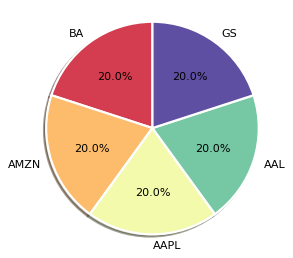

In [4]:
print("Participacion en cada activo:", M.W)

import matplotlib.pyplot as plt
plt.figure(dpi=80)
plt.pie(M.W, labels=M.stocks, colors=[plt.get_cmap('Spectral')(i) for i in np.linspace(0.1, 1, M.n)],
        wedgeprops={'linewidth': 2, 'edgecolor' : 'w'},autopct='%1.1f%%',shadow=True, startangle=90, radius=1.1)
plt.show()

(530, 5)


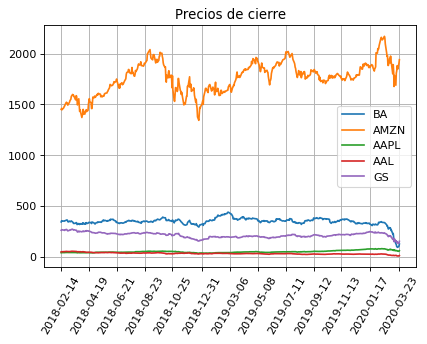

In [5]:
# Datos descargados (Precio de cierre)
print(M.data.shape)
M.grafico(M.data,"Precios de cierre")

(529, 5)


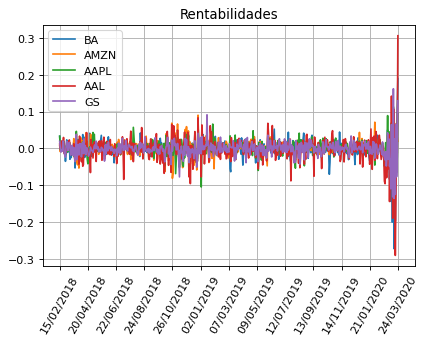

In [6]:
# Rentabilidad de cada activo
print(M.rent.shape)
M.grafico(M.rent,"Rentabilidades")

(529, 1)


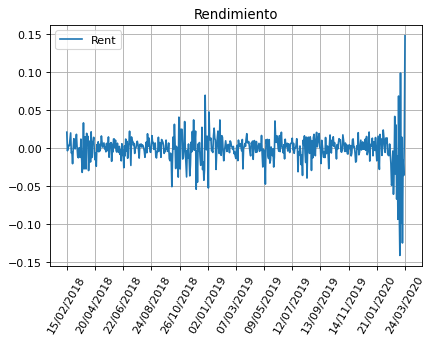

In [7]:
# Rendimiento del portafolio
print(M.rend.shape)
M.grafico(M.rend,"Rendimiento")

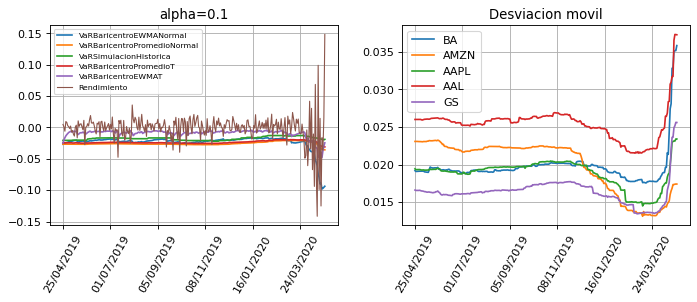

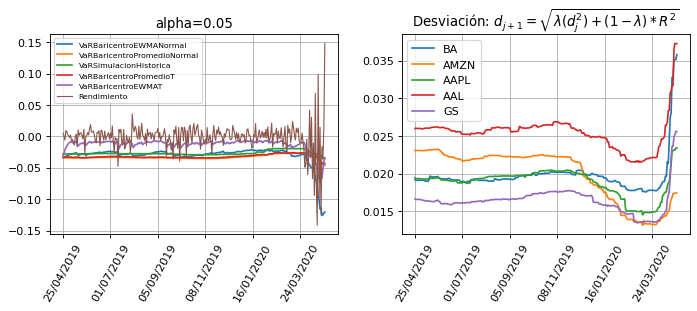

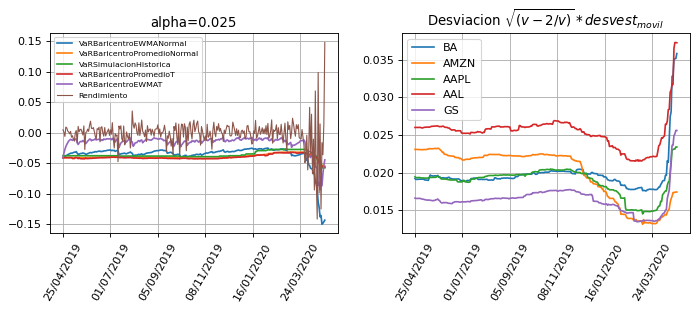

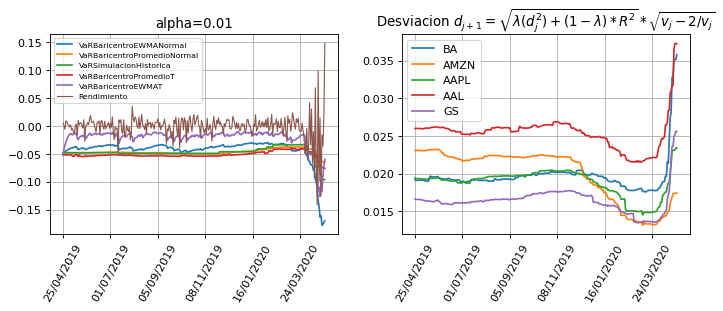

In [8]:
Metodos = [M.VaRBaricentroEWMANormal,
           M.VaRBaricentroPromedioNormal,
           M.VaRSimulacionHistorica,
           M.VaRBaricentroPromedioT,
           M.VaRBaricentroEWMAT]
m = ["VaRBaricentroEWMANormal", "VaRBaricentroPromedioNormal",
     "VaRSimulacionHistorica", "VaRBaricentroPromedioT", "VaRBaricentroEWMAT"]

title=["Desviacion movil",
       u"Desviación: $d_{j+1}=\sqrt{\lambda(d_{j}^{2})+(1-\lambda)*R^2}$",
       u"Desviacion $\sqrt{(v-2/v)}*desvest_{movil}$",
       u"Desviacion $d_{j+1}=\sqrt{\lambda(d_{j}^{2})+(1-\lambda)*R^2}*\sqrt{v_j-2/v_j}$"]
for mm,i in enumerate(alphas):
    fig = plt.figure(figsize=(8,2.5), dpi=80)
    ax1 = fig.add_axes([0,0,0.45,1])
    ax2 = fig.add_axes([0.55,0,0.45,1])
    for k,j in enumerate(Metodos):
        ax1.plot(j()["alpha="+str(i)], label=m[k])
        ax1.set_title("alpha="+str(i))
        if k<5:
            ax2.plot(M.get_desvest(M.stocks[k]), label=M.stocks[k])
    ax1.set_xticklabels(M.fechas[::len(M.fechas)//6],rotation=60)
    ax2.set_xticklabels(M.fechas[::len(M.fechas)//6],rotation=60)
    ax1.plot(M.rend["Rent"].values[-M.periodos:], lw=1, label="Rendimiento")
    ax1.legend( fontsize=7),ax1.grid()
    ax2.set_title(title[mm])
    ax2.legend(),ax2.grid()
    plt.show()

In [9]:
u = M.VaRSimulacionHistorica()
M.excepciones(u).head()#[M.excepciones(u)["alpha=0.1"]==True]

,Fechas,alpha=0.1,alpha=0.05,alpha=0.025,alpha=0.01
0,19/02/2019,False,False,False,False
1,20/02/2019,False,False,False,False
2,21/02/2019,False,False,False,False
3,22/02/2019,False,False,False,False
4,25/02/2019,False,False,False,False


In [10]:
M.BackTesting(u)

,0,1,2,3
BackTesting,27.7,13.85,6.925,2.77
x,29,19,13,9
p,0.1,0.05,0.025,0.01
p estimado,0.104693,0.0685921,0.0469314,0.032491
m,277,277,277,277
nivel de significancia,0.05,0.05,0.05,0.05
test de kupiec,0.066869,1.81529,4.36278,8.89341
Valor P,1.49203,0.119468,0.0215607,0.00156746
Zona de rechazo,No Rechazo H0,No Rechazo H0,Rechazo H0,Rechazo H0
Valor de eficiencia,0.895307,0.931408,0.953069,0.967509
